In [490]:
import pandas as pd
import numpy as np
import re
import datetime as dt #for working with times objects

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
from folium.plugins import HeatMap

In [491]:
#Reading in the cleansed data
la_set = pd.read_pickle("la_set.pkl")
la_set

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,exact_duration
0,2019-01-01 00:07:00,2019-01-01 00:14:00,3046,3051,6468,Walk-up,2nd & Hill,7th & Broadway,0 days 00:07:00
1,2019-01-01 00:08:00,2019-01-01 00:14:00,3046,3051,12311,Walk-up,2nd & Hill,7th & Broadway,0 days 00:06:00
2,2019-01-01 00:18:00,2019-01-01 00:50:00,3030,3075,5992,Walk-up,Main & 1st,Broadway & 9th,0 days 00:32:00
3,2019-01-01 00:20:00,2019-01-01 00:50:00,3030,3075,5860,Walk-up,Main & 1st,Broadway & 9th,0 days 00:30:00
4,2019-01-01 00:22:00,2019-01-01 00:50:00,3030,3075,6006,Walk-up,Main & 1st,Broadway & 9th,0 days 00:28:00
...,...,...,...,...,...,...,...,...,...
270650,2019-12-31 23:34:46,2019-12-31 23:42:28,3063,3069,12019,Walk-up,Pershing Square,Broadway & 3rd,0 days 00:07:42
270651,2019-12-31 23:41:52,2019-12-31 23:50:58,4491,3022,18912,Monthly Pass,Main & Winston,3rd & Santa Fe,0 days 00:09:06
270652,2019-12-31 23:43:19,2019-12-31 23:47:41,3051,3064,12298,Annual Pass,7th & Broadway,Grand & 8th,0 days 00:04:22
270653,2019-12-31 23:48:17,2019-12-31 23:53:55,3064,3074,19053,Annual Pass,Grand & 8th,Hope & Olympic,0 days 00:05:38


In [492]:
la_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 270635 entries, 0 to 270654
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype          
---  ------              --------------   -----          
 0   start_time          270635 non-null  datetime64[ns] 
 1   end_time            270635 non-null  datetime64[ns] 
 2   start_station_id    270635 non-null  int64          
 3   end_station_id      270635 non-null  int64          
 4   bike_id             270635 non-null  object         
 5   user_type           270635 non-null  object         
 6   start_station_name  270635 non-null  object         
 7   end_station_name    270635 non-null  object         
 8   exact_duration      270635 non-null  timedelta64[ns]
dtypes: datetime64[ns](2), int64(2), object(4), timedelta64[ns](1)
memory usage: 20.6+ MB


# Descriptive analytics

In [493]:
# Get the fleet size and the number of stations
fleet_size = len(la_set["bike_id"].unique())
station_amount = len(la_set["start_station_id"].unique())

print("The LA fleet consists of {} bikes".format(fleet_size), "and there are {} stations, which were used in 2019.".format(station_amount))

The LA fleet consists of 2411 bikes and there are 230 stations, which were used in 2019.


# Temporal demand patterns and seasonality

In [494]:
# Amount of bike rentings grouped by date
day_demand = pd.DataFrame({'amount': la_set.groupby(la_set['start_time'].apply(lambda x: x.date())).size()})

day_demand.reset_index(inplace=True)
day_demand = day_demand.rename(columns = {'start_time':'date'})
day_demand['weekday'] = day_demand['date'].apply(lambda x: x.weekday())
day_demand["User types"] = la_set["user_type"]

day_demand

,date,amount,weekday,User types
0,2019-01-01,488,1,Walk-up
1,2019-01-02,654,2,Walk-up
2,2019-01-03,714,3,Walk-up
3,2019-01-04,777,4,Walk-up
4,2019-01-05,265,5,Walk-up
...,...,...,...,...
360,2019-12-27,690,4,Walk-up
361,2019-12-28,635,5,One Day Pass
362,2019-12-29,525,6,Walk-up
363,2019-12-30,792,0,Walk-up


## Demand over the year

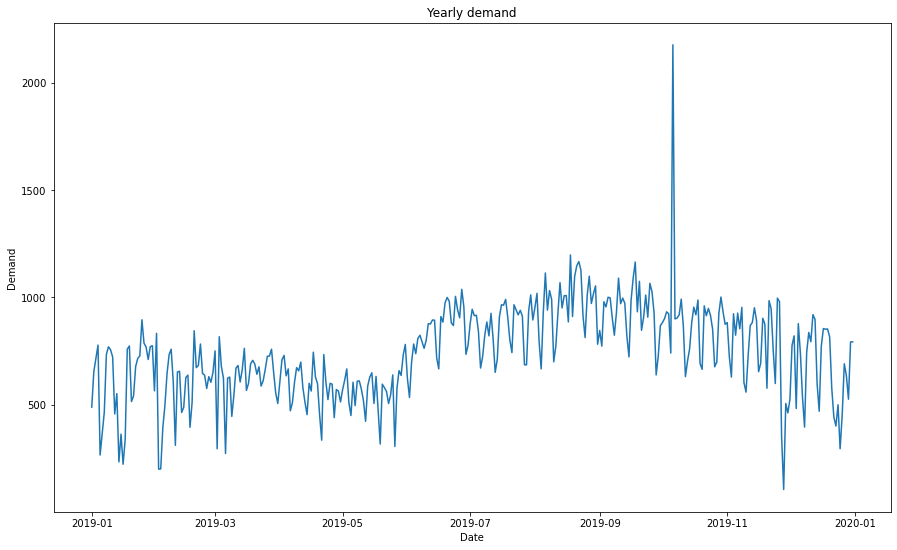

In [495]:
# Getting the demand over the year
fig, ax = plt.subplots(figsize = (15,9))

# Plotting the data
ax.plot(day_demand["date"],day_demand[["amount"]])
ax.set_xlabel("Date")
ax.set_ylabel("Demand")
ax.set_title("Yearly demand")

plt.show()

In [496]:
#search for max demand 
day_demand.iloc[day_demand['amount'].argmax()]
# why so high?
# maybe https://www.ciclavia.org/ciclavia_heart_of_la19 : city partly closed for cars

date            2019-10-06
amount                2176
weekday                  6
User types    Monthly Pass
Name: 278, dtype: object

In [497]:
#search for min demand 
day_demand.iloc[day_demand['amount'].argmin()]
# why so low -> big storm 

date          2019-11-28
amount               104
weekday                3
User types       Walk-up
Name: 331, dtype: object

## Demand over the months

In [498]:
# Getting the monthly demand
month_demand = pd.DataFrame({'amount': la_set.groupby(by=[la_set['start_time'].apply(lambda x: x.date()),
                                                        la_set['start_time'].apply(lambda x: x.month)]).size()})


month_demand.reset_index(level=0, inplace=True)

month_demand = month_demand.rename(columns = {'start_time':'date'})

month_demand.reset_index(inplace=True)

month_demand = month_demand.rename(columns = {'start_time':'month'})

month_demand["User types"] = la_set["user_type"] 

month_demand

,month,date,amount,User types
0,1,2019-01-01,488,Walk-up
1,1,2019-01-02,654,Walk-up
2,1,2019-01-03,714,Walk-up
3,1,2019-01-04,777,Walk-up
4,1,2019-01-05,265,Walk-up
...,...,...,...,...
360,12,2019-12-27,690,Walk-up
361,12,2019-12-28,635,One Day Pass
362,12,2019-12-29,525,Walk-up
363,12,2019-12-30,792,Walk-up


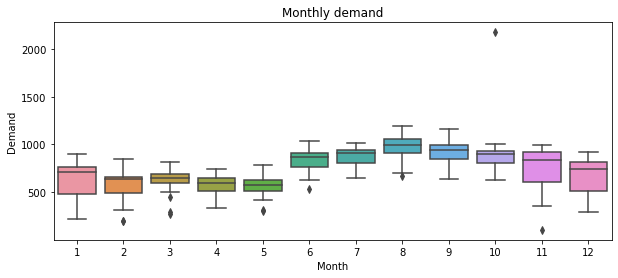

In [499]:
# Getting the monthly demand 
fig,ax = plt.subplots(figsize=(10,4))

sns.boxplot(x=month_demand["month"], y=month_demand["amount"], ax=ax)

ax.set_xlabel("Month")
ax.set_ylabel("Demand")
ax.set_title("Monthly demand")

plt.show()

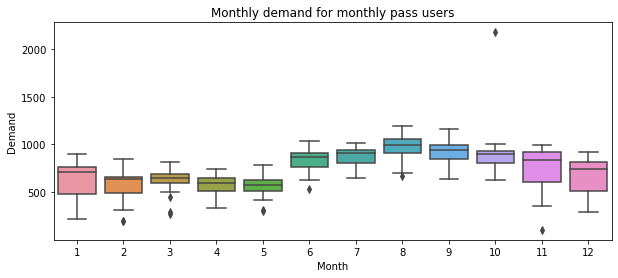

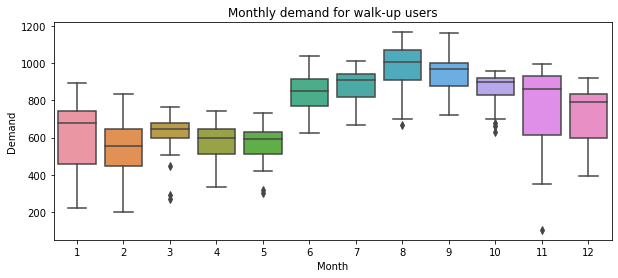

In [500]:
# Getting the different demands per user type to see if there are any differences

# Monthly demand of Monthly pass users

fig,ax = plt.subplots(figsize=(10,4))

month_demand_mp = month_demand[(month_demand["User types"] == "Monthly Pass")]

sns.boxplot(x=month_demand["month"], y=month_demand["amount"], ax=ax)

ax.set_xlabel("Month")
ax.set_ylabel("Demand")
ax.set_title("Monthly demand for monthly pass users")

plt.show()

# Monthly demand of walk-up useres

fig,ax = plt.subplots(figsize=(10,4))

month_demand_wu = month_demand[(month_demand["User types"] == "Walk-up")]

sns.boxplot(x=month_demand_wu["month"], y=month_demand_wu["amount"], ax=ax)

ax.set_xlabel("Month")
ax.set_ylabel("Demand")
ax.set_title("Monthly demand for walk-up users")

plt.show()

## Demand over the week

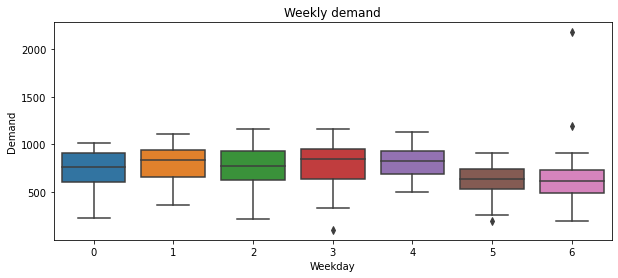

In [501]:
# Getting the demand over the week
fig,ax = plt.subplots(figsize=(10,4)) 

sns.boxplot(x=day_demand['weekday'], y=day_demand["amount"],ax=ax)

ax.set_xlabel("Weekday")
ax.set_ylabel("Demand")
ax.set_title("Weekly demand")

plt.show()

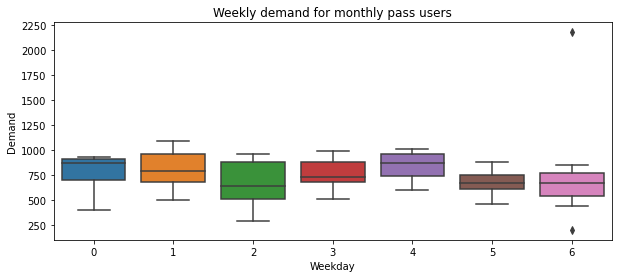

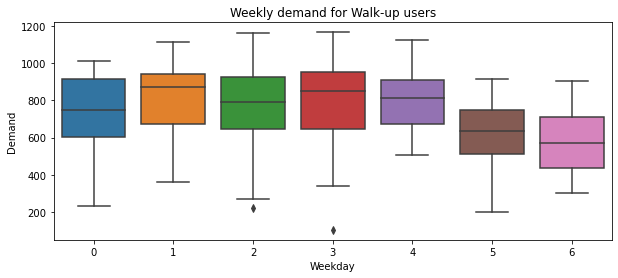

In [502]:
# Getting the different demands per user type, to see if there are any differences

# Demand per week of monthly pass users 

fig,ax = plt.subplots(figsize=(10,4)) 

day_demand_mp = day_demand[(day_demand["User types"] == "Monthly Pass")]


sns.boxplot(x=day_demand_mp['weekday'], y=day_demand_mp["amount"],ax=ax)

ax.set_xlabel("Weekday")
ax.set_ylabel("Demand")
ax.set_title("Weekly demand for monthly pass users")

plt.show()

# Demand per week of walk-up users users 

fig,ax = plt.subplots(figsize=(10,4)) 

day_demand_wu = day_demand[(day_demand["User types"] == "Walk-up")]


sns.boxplot(x=day_demand_wu['weekday'], y=day_demand_wu["amount"],ax=ax)

ax.set_xlabel("Weekday")
ax.set_ylabel("Demand")
ax.set_title("Weekly demand for Walk-up users")

plt.show()


# Geographical demand patterns

## Popular and unpopular stations

In [503]:
# Geographical Demand Patterns:
# which stations are popular, which are not?

# Get popular start stations
popular_start_stations = la_set["start_station_id"].value_counts()
print("popular start stations:\n", popular_start_stations.head(20), "\n")

# Get popular end stations
popular_end_stations = la_set["end_station_id"].value_counts()
print("popular end stations:\n", popular_end_stations.head(20), "\n")

print("unpopular start stations:\n", popular_start_stations[-20:], "\n")

print("unpopular end stations:\n", popular_end_stations[-20:], "\n")
# -> count how many times station is mentioned (seperate start and stop?); maybe select routes that appear often

routes = la_set.groupby(['start_station_id', 'end_station_id']).size().sort_values(ascending=False)
print("popular routes: ")
routes.head(15)
# -> use api to visualize?

# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html // how to join on station_id to print names next to it + region

popular start stations:
 3005    13627
3030    12891
3014    10634
3031     8503
3006     6527
3035     6075
3042     5879
4345     5793
3064     5481
3007     5008
3067     4967
3038     4840
3074     4703
3082     4631
3069     4417
3027     4350
3032     4072
4346     3986
3049     3909
3063     3882
Name: start_station_id, dtype: int64 

popular end stations:
 3005    14536
3014    11939
3030    11329
3031     9062
3006     6759
3042     6756
4345     6302
3035     6231
3064     5824
3082     5324
3032     4597
3067     4590
3074     4576
3069     4438
3038     4405
3007     4359
3063     4320
3034     3888
3075     3740
3027     3739
Name: end_station_id, dtype: int64 

unpopular start stations:
 4125    35
4462    30
4493    29
4422    29
4213    28
4482    27
4473    27
4457    26
4463    25
4461    23
4484    19
4469    16
4439    13
4395    11
4369     9
4108     7
4363     7
4374     4
4327     1
4490     1
Name: start_station_id, dtype: int64 

unpopular end stations:
 4473 

start_station_id  end_station_id
3030              3014              5135
3014              3030              4395
4345              4345              3313
4346              4346              1831
3030              3042              1395
3042              3030              1395
3014              3016              1302
4126              4126              1236
4346              4345              1129
4344              4344              1121
3016              3014              1097
3005              3005              1097
3031              3005              1045
3005              3031               994
3006              3006               791
dtype: int64

In [504]:
# loading dataset withg the coordinates
coordinates_file = "C:\\Users\\gerialiaj\\Desktop\\Uni\\SS21\\DSML\\Gruppen Projekt\\SiliconValley-main-9"
coordinates = pd.read_csv("metro-bike-share-trips-2019-q1.csv", sep=",", low_memory = False)
coordinates = pd.read_csv("metro-bike-share-trips-2019-q2.csv", sep=",", low_memory = False)
coordinates = pd.read_csv("metro-bike-share-trips-2019-q3.csv", sep=",", low_memory = False)

#Can't put that in, because the NaN values cant getted dropped
#coordinates = pd.read_csv("metro-bike-share-trips-2019-q4.csv", sep=",", low_memory = False)

In [505]:
# counting the number of start and end stations
count_start = la_set["start_station_name"].value_counts()
count_end = la_set["end_station_name"].value_counts()

In [506]:
# aggregating; started trip and ended trip is one total trip
total_trips = count_start.to_frame().merge(count_end,left_on=count_start.index,right_on=count_end.index,how="outer")
total_trips = total_trips.rename(columns={"key_0":"station_name","end_station_name":"ended_trips","start_station_name":"started_trips"})

# setting null values to 0
total_trips = total_trips.fillna(value=0)

# adding trips column
total_trips["trips"] = total_trips["ended_trips"]+total_trips["started_trips"]
total_trips.head()

#adding coordinates to stations
coordinates["name"] = total_trips["station_name"]

coordinates["station_coordinates"] = list(zip(coordinates["start_lat"],coordinates["start_lon"]))
total_trips = total_trips.merge(coordinates["station_coordinates"].to_frame(),how = "left",left_on=total_trips["station_name"],right_on=coordinates["name"])
total_trips = total_trips.drop(columns = ['key_0'])

#Drop NaN values
#total_trips = total_trips.dropna()

#Reset indices
#total_trips = total_trips.reset_index(drop = True)

#dropping stations without location data
total_trips = total_trips.dropna(axis=0)
total_trips = total_trips.sort_values(by="trips",ascending=False)
total_trips.head(20)

,station_name,started_trips,ended_trips,trips,station_coordinates
0,7th & Flower,13627.0,14536,28163.0,"(34.066990000000004, -118.290878)"
1,Main & 1st,12891.0,11329,24220.0,"(34.063389, -118.23616000000001)"
2,Union Station West Portal,10634.0,11939,22573.0,"(34.063351000000004, -118.296799)"
3,7th & Spring,8503.0,9062,17565.0,"(34.028511, -118.25666799999999)"
4,Ocean Front Walk & Navy,7095.0,7309,14404.0,"(34.048401, -118.260948)"
5,Olive & 8th,6527.0,6759,13286.0,"(34.037459999999996, -118.265381)"
7,1st & Central,5879.0,6756,12635.0,"(34.05088, -118.248253)"
6,Figueroa & 8th,6075.0,6231,12306.0,"(34.039982, -118.266403)"
8,Grand & 8th,5481.0,5824,11305.0,"(34.05661, -118.23721299999998)"
14,Traction & Rose,4631.0,5324,9955.0,"(34.0485, -118.25853700000002)"


## Heatmap

In [507]:
#Stations; number of started tours makes up the size
log_map = folium.Map(location=(34.051941, -118.24353),tiles='OpenStreetMap',zoom_start=11, control_scale=True, max_zoom=20)

#Blue dots: Station with more started than ended trips
#Cyan blue dots: Station with more ended than started trips

#Putting dots on the map
for index, row in total_trips.iterrows():
    diff_color = "cyan" if row["started_trips"] > row["ended_trips"] else "blue"
    folium.CircleMarker(radius=np.power(np.log(row["trips"])/4,3), location=row["station_coordinates"], popup=row["station_name"], color=diff_color, fill_color=diff_color,weight=1).add_to(log_map)

#Preventing jupyter notebook from cutting of map height
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height:unset !important; }</style>"))

log_map

In [508]:
#Drawing most and least used stations on a map
log_map = folium.Map(location=(34.051941, -118.24353),tiles='OpenStreetMap',zoom_start=11, control_scale=True, max_zoom=20)

#Blue dots: most used
#Violet dots: least used

#Adding the most used stations
for index, row in total_trips.iloc[:100].iterrows():
    folium.CircleMarker(radius=5, location=row["station_coordinates"], popup=row["station_name"], color="blue", fill_color="blue").add_to(log_map)
    
#Adding the least used stations
for index, row in total_trips.iloc[-100:].iterrows():
    folium.CircleMarker(radius=5, location=row["station_coordinates"], popup=row["station_name"], color="violet", fill_color="magenta").add_to(log_map)
    
log_map

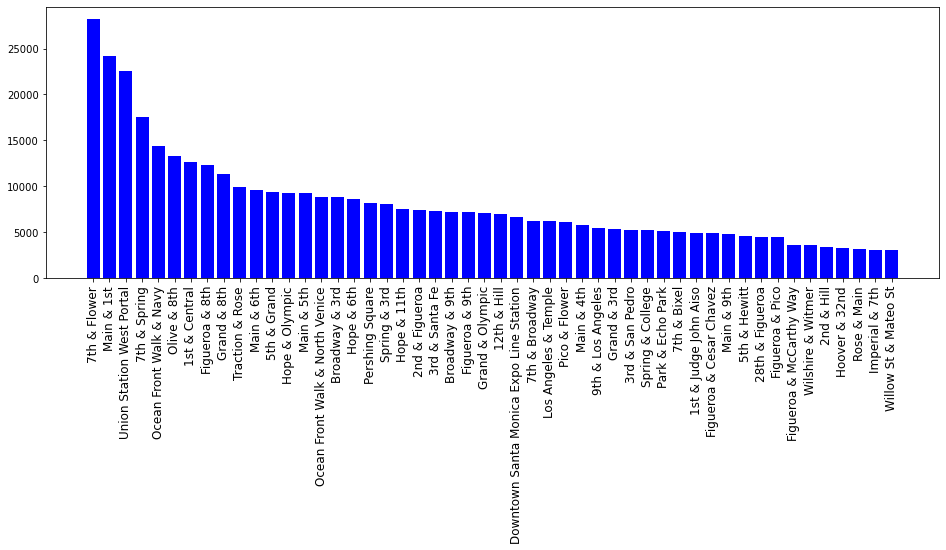

In [509]:
# sorting stations by highest total trips (started and ended trips)

fig, ax = plt.subplots(figsize=[16,5])
plt.setp(ax.xaxis.get_majorticklabels(),rotation=90,fontsize=12)
ax.bar(total_trips["station_name"].iloc[:50], total_trips["trips"].iloc[:50], color = "blue")
color = "blue"

<BarContainer object of 50 artists>

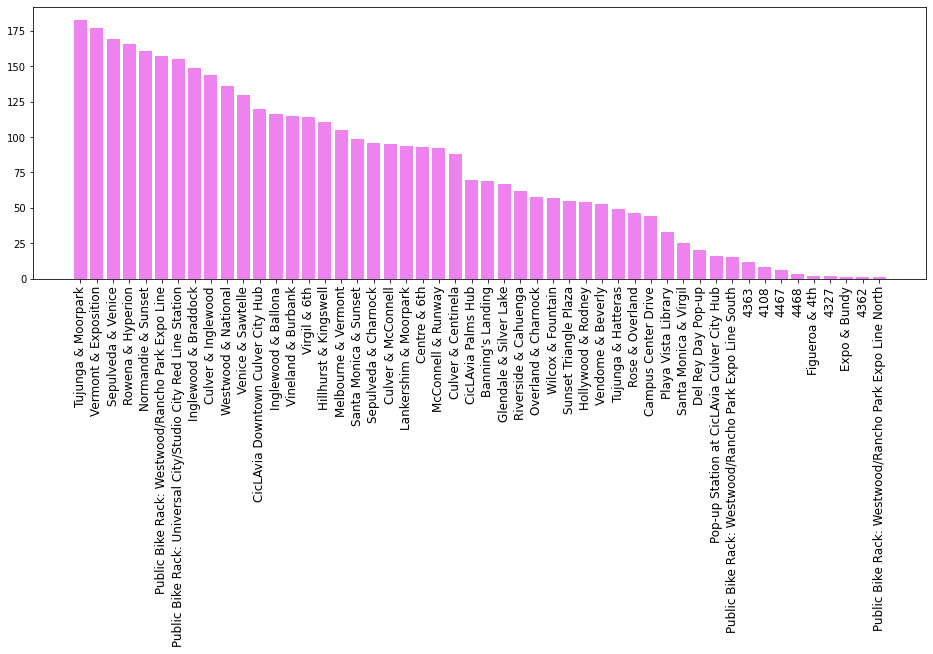

In [510]:
# sorting stations by least total trips (started and ended trips)

fig, ax = plt.subplots(figsize=[16,5])
plt.setp(ax.xaxis.get_majorticklabels(),rotation=90,fontsize=12)
ax.bar(total_trips["station_name"].iloc[-50:], total_trips["trips"].iloc[-50:], color = "violet")

# KPI's 

In [511]:
# Key Performance Indicators (3+) and dashboard for fleet operators:

    #KPI's 
    # -> Peak times over the day for different user types and in total (revenue, utilization and coverage)
    # -> Utilization of bikes (utilization)
    # -> Amount of user types (revenue)
    # -> Average duration time (revenue, coverage)

In [512]:
# Getting the demand per hour to provide our KPI's with and look for trends

hour_demand = pd.DataFrame({'amount': la_set.groupby(by=[la_set['start_time'].apply(lambda x: x.date()),
                                                        la_set['start_time'].apply(lambda x: x.hour)]).size()})



hour_demand.reset_index(level=0, inplace=True)

hour_demand = hour_demand.rename(columns = {'start_time':'date'})

hour_demand.reset_index(inplace=True)

hour_demand = hour_demand.rename(columns = {'start_time':'hour'})

hour_demand['Fleet size']= fleet_size

hour_demand['User types'] = la_set['user_type']

hour_demand

,hour,date,amount,Fleet size,User types
0,0,2019-01-01,19,2411,Walk-up
1,1,2019-01-01,8,2411,Walk-up
2,2,2019-01-01,16,2411,Walk-up
3,3,2019-01-01,2,2411,Walk-up
4,6,2019-01-01,1,2411,Walk-up
...,...,...,...,...,...
8345,19,2019-12-31,37,2411,Annual Pass
8346,20,2019-12-31,41,2411,Monthly Pass
8347,21,2019-12-31,22,2411,Monthly Pass
8348,22,2019-12-31,20,2411,Walk-up


## Amount of user types 

In [513]:
#Getting the total amount of the different user types
user_types_total = pd.DataFrame(la_set["user_type"].value_counts())
user_types_total = user_types_total.rename(columns = {'user_type':'amount'})

user_types_total

,amount
Monthly Pass,165730
Walk-up,72499
Annual Pass,20201
One Day Pass,11867
Flex Pass,309
Testing,29


(array([7.2499e+04, 0.0000e+00, 1.6573e+05, 0.0000e+00, 2.0201e+04,
        0.0000e+00, 1.1867e+04, 0.0000e+00, 3.0900e+02, 2.9000e+01]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

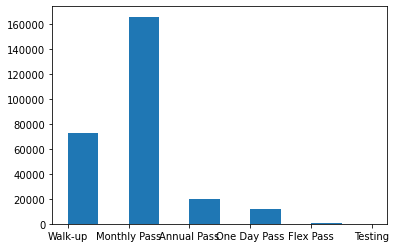

In [514]:
plt.hist(la_set["user_type"])

Monthly pass users and walk-up users make up for more than 90% of all drives

## Which group drives more than 30 minutes?

In [515]:
a = dt.timedelta(minutes=30)
#amount of monthly passes > 30 min
monthly_passes_higher30 = la_set[(la_set["user_type"] == "Monthly Pass") & (la_set["exact_duration"] > a)]
print("Monthly Pass > 30 minutes:", len(monthly_passes_higher30))

#amount of monthly passes < 30 min
monthly_passes_lower30 = la_set[(la_set["user_type"] == "Monthly Pass") & (la_set["exact_duration"] <= a)]
print("Monthly Pass <= 30 minutes:", len(monthly_passes_lower30))


#amount of Walk-ups > 30 min
walk_ups_higher30 = la_set[(la_set["user_type"] == "Walk-up") & (la_set["exact_duration"] > a)]
print("Walk-up > 30 minutes:", len(walk_ups_higher30))

#amount of Walk-ups < 30 min
walk_ups_lower30 = la_set[(la_set["user_type"] == "Walk-up") & (la_set["exact_duration"] <= a)]
print("Walk-up <= 30 minutes:", len(walk_ups_lower30))

print("Walk-up users drive over 3 times more, longer than 30 minutes, compared to the monthly pass users, even though they are by far the biggest group of bike users. Generally, Walk-ups bring more money per drive than monthly pass users, but since the demand is depending on the weather, monthly pass users pay for the rainy days too and bring more revenue in general, just because they are the biggest group")

Monthly Pass > 30 minutes: 7246
Monthly Pass <= 30 minutes: 158484
Walk-up > 30 minutes: 25500
Walk-up <= 30 minutes: 46999
Walk-up users drive over 3 times more, longer than 30 minutes, compared to the monthly pass users, even though they are by far the biggest group of bike users. Generally, Walk-ups bring more money per drive than monthly pass users, but since the demand is depending on the weather, monthly pass users pay for the rainy days too and bring more revenue in general, just because they are the biggest group


## Demand per hour

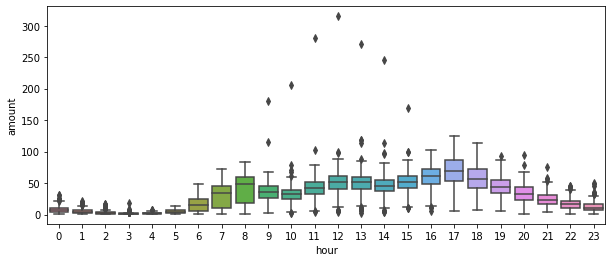

The plot shows us that it's best to charge and maintain the bikes between 22pm and 6am, when demand is at its lowest


In [516]:
#Demand per hour overall
fig,ax = plt.subplots(figsize=(10,4))

sns.boxplot(x=hour_demand["hour"], y=hour_demand["amount"], ax=ax)
plt.show()

print("The plot shows us that it's best to charge and maintain the bikes between 22pm and 6am, when demand is at its lowest")

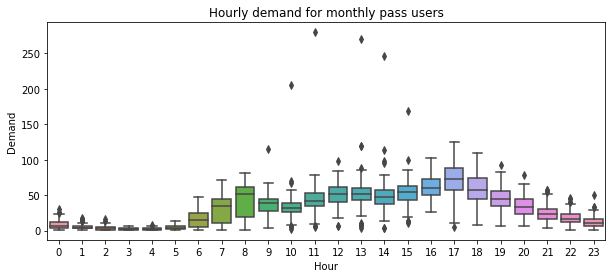

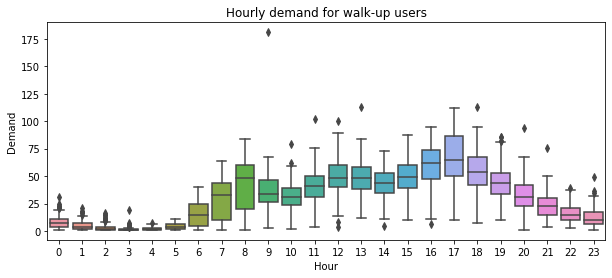

In [517]:
#Demand per hour for monthly pass users 
fig,ax = plt.subplots(figsize=(10,4))

hour_demand_mp = hour_demand[(hour_demand["User types"] == "Monthly Pass")]

sns.boxplot(x=hour_demand_mp["hour"], y=(hour_demand_mp["amount"]))

ax.set_xlabel("Hour")
ax.set_ylabel("Demand")
ax.set_title("Hourly demand for monthly pass users")

plt.show()

#Demand per hour for walk up users 
fig,ax = plt.subplots(figsize=(10,4))

hour_demand_wu = hour_demand[(hour_demand["User types"] == "Walk-up")]

sns.boxplot(x=hour_demand_wu["hour"], y=(hour_demand_wu["amount"]))

ax.set_xlabel("Hour")
ax.set_ylabel("Demand")
ax.set_title("Hourly demand for walk-up users")

plt.show()

## Utilization

In [518]:
# Calculating the utilization of the fleet
df_new = hour_demand.loc[:,"amount"].div(hour_demand["Fleet size"], axis=0)

In [519]:
# Creating new row for the fleet utilization
hour_demand['Fleet utilization']= df_new

hour_demand

,hour,date,amount,Fleet size,User types,Fleet utilization
0,0,2019-01-01,19,2411,Walk-up,0.007881
1,1,2019-01-01,8,2411,Walk-up,0.003318
2,2,2019-01-01,16,2411,Walk-up,0.006636
3,3,2019-01-01,2,2411,Walk-up,0.000830
4,6,2019-01-01,1,2411,Walk-up,0.000415
...,...,...,...,...,...,...
8345,19,2019-12-31,37,2411,Annual Pass,0.015346
8346,20,2019-12-31,41,2411,Monthly Pass,0.017005
8347,21,2019-12-31,22,2411,Monthly Pass,0.009125
8348,22,2019-12-31,20,2411,Walk-up,0.008295


## Fleet utilization over the year per day

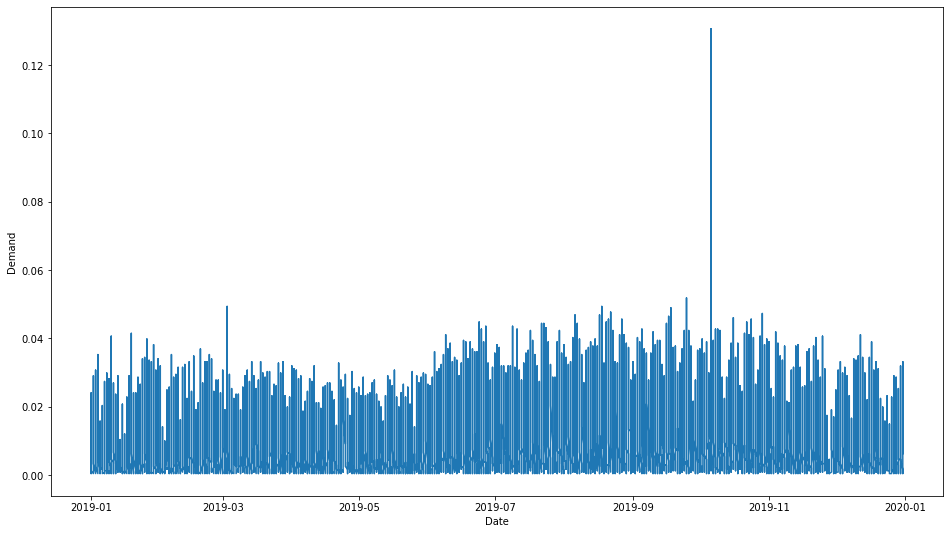

The fleet is almost never utilized for more than 5% over a day


In [520]:
fig, ax = plt.subplots(figsize = (16,9))

# Plotting the utilization data
ax.plot(hour_demand["date"],hour_demand[["Fleet utilization"]])
ax.set_xlabel("Date")
ax.set_ylabel("Demand")
plt.show()
print("The fleet is almost never utilized for more than 5% over a day")

## Amount of bikes used 

In [521]:
#Most used bikes
most_used_bikes = la_set["bike_id"].value_counts()
print("Most used bikes:\n", most_used_bikes.head(10), "\n")

#Least used bikes
most_used_bikes = la_set["bike_id"].value_counts()
print("Least used bikes:\n", most_used_bikes.tail(500), "\n")

print("There are over 500 bikes that were used less than 30 times a year, while some bikes were used more than 700 times. That makes 1/5 of the bikes mostly unused over the year")

Most used bikes:
 16422    903
16997    794
17584    757
16329    739
16392    722
18841    713
19081    709
17340    701
19178    693
19895    684
Name: bike_id, dtype: int64 

Least used bikes:
 15851    29
16114    29
6625     29
17523    29
15920    29
         ..
17144     1
20027     1
20130     1
20169     1
15673     1
Name: bike_id, Length: 500, dtype: int64 

There are over 500 bikes that were used less than 30 times a year, while some bikes were used more than 700 times. That makes 1/5 of the bikes mostly unused over the year


## Average Duration

In [522]:
def get_total_hours (td):
    return (int)(td.total_seconds() / 3600)

def get_total_minute (td):
    return (int)(td.total_seconds() / 60)

In [523]:
la_set["minutes"] = la_set["exact_duration"].apply(lambda x:int(x.total_seconds() / 60))
la_set

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,exact_duration,minutes
0,2019-01-01 00:07:00,2019-01-01 00:14:00,3046,3051,6468,Walk-up,2nd & Hill,7th & Broadway,0 days 00:07:00,7
1,2019-01-01 00:08:00,2019-01-01 00:14:00,3046,3051,12311,Walk-up,2nd & Hill,7th & Broadway,0 days 00:06:00,6
2,2019-01-01 00:18:00,2019-01-01 00:50:00,3030,3075,5992,Walk-up,Main & 1st,Broadway & 9th,0 days 00:32:00,32
3,2019-01-01 00:20:00,2019-01-01 00:50:00,3030,3075,5860,Walk-up,Main & 1st,Broadway & 9th,0 days 00:30:00,30
4,2019-01-01 00:22:00,2019-01-01 00:50:00,3030,3075,6006,Walk-up,Main & 1st,Broadway & 9th,0 days 00:28:00,28
...,...,...,...,...,...,...,...,...,...,...
270650,2019-12-31 23:34:46,2019-12-31 23:42:28,3063,3069,12019,Walk-up,Pershing Square,Broadway & 3rd,0 days 00:07:42,7
270651,2019-12-31 23:41:52,2019-12-31 23:50:58,4491,3022,18912,Monthly Pass,Main & Winston,3rd & Santa Fe,0 days 00:09:06,9
270652,2019-12-31 23:43:19,2019-12-31 23:47:41,3051,3064,12298,Annual Pass,7th & Broadway,Grand & 8th,0 days 00:04:22,4
270653,2019-12-31 23:48:17,2019-12-31 23:53:55,3064,3074,19053,Annual Pass,Grand & 8th,Hope & Olympic,0 days 00:05:38,5


In [524]:
# Calculate the average biking time
time_zero = pd.to_datetime('2019-01-01 00:00:00')

df1 = la_set[['start_time', 'minutes']]
df1 = df1.groupby(df1['start_time'].apply(lambda x: get_total_hours(x-time_zero))).sum()
df1.reset_index(level=0, inplace=True)
df1['amount'] = hour_demand["amount"]
df1['Average biking time'] = df1.loc[:,"minutes"].div(df1['amount'], axis = 0)


df1

,start_time,minutes,amount,Average biking time
0,0,299,19,15.736842
1,1,277,8,34.625000
2,2,733,16,45.812500
3,3,60,2,30.000000
4,6,4,1,4.000000
...,...,...,...,...
8345,8755,3046,37,82.324324
8346,8756,724,41,17.658537
8347,8757,336,22,15.272727
8348,8758,668,20,33.400000


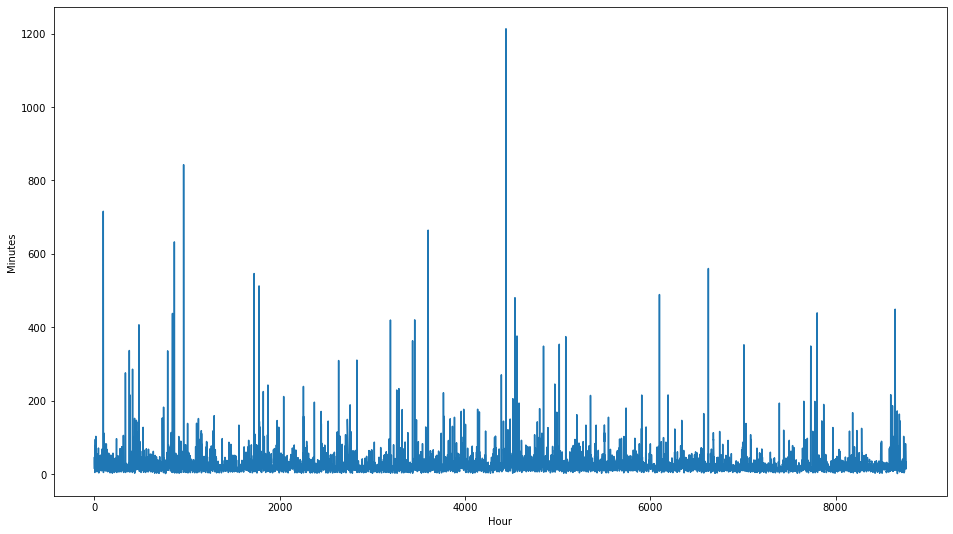

In [525]:
fig, ax = plt.subplots(figsize = (16,9))

# Plotting the data
ax.plot(df1["start_time"],df1[["Average biking time"]])
ax.set_xlabel("Hour")
ax.set_ylabel("Minutes")
plt.show()

